# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
225651,2020-09-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225652,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225653,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225654,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225655,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
225651,2020-09-16,Colombia,Vichada,14,0,0,14
225652,2020-09-17,Colombia,Vichada,14,0,0,14
225653,2020-09-18,Colombia,Vichada,14,0,0,14
225654,2020-09-19,Colombia,Vichada,14,0,0,14
225655,2020-09-20,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
181,2020-09-16,23437,2445,389,20603
182,2020-09-17,23608,2382,389,20837
183,2020-09-18,23828,2417,390,21021
184,2020-09-19,24046,2448,390,21208
185,2020-09-20,24208,2610,390,21208


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-09-16,29620422,8583070,936924,20100428,0.015816,0.339300,0.044536
2020-09-17,29925470,8677381,942203,20305886,0.015742,0.339274,0.044343
2020-09-18,30241774,8732072,947929,20561773,0.015673,0.339956,0.044070
2020-09-19,30502351,8766671,952557,20783123,0.015614,0.340681,0.043825
2020-09-20,30502880,8837264,952561,20713055,0.015614,0.339526,0.043966


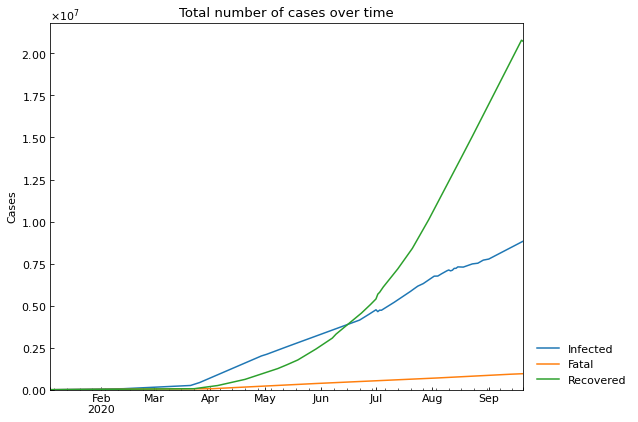

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
220,2020-09-16,77021,7039,1479,68503
221,2020-09-17,77512,6801,1488,69223
222,2020-09-18,78084,6721,1498,69865
223,2020-09-19,78685,6747,1502,70436
224,2020-09-20,79165,77659,1506,69492


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
218,2020-09-16,76448,6455,1461,68532
219,2020-09-17,77009,6283,1473,69253
220,2020-09-18,77494,6113,1482,69899
221,2020-09-19,78073,6083,1495,70495
222,2020-09-20,78657,6127,1500,71030


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
225651,2020-09-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225652,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225653,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225654,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225655,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
205401,COL,Colombia,Vichada,2020-09-16,107808
205402,COL,Colombia,Vichada,2020-09-17,107808
205403,COL,Colombia,Vichada,2020-09-18,107808
205404,COL,Colombia,Vichada,2020-09-19,107808
205405,COL,Colombia,Vichada,2020-09-20,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
225651,2020-09-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225652,2020-09-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225653,2020-09-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225654,2020-09-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
225655,2020-09-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
225651,2020-09-16,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
225652,2020-09-17,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
225653,2020-09-18,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
225654,2020-09-19,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
225655,2020-09-20,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
256,2020-09-16,1,1,1,0,0,1,1,3,2,2,1,37.04
257,2020-09-17,1,1,1,0,0,1,1,3,2,2,1,37.04
258,2020-09-18,1,1,1,0,0,1,1,3,2,2,1,37.04
259,2020-09-19,1,1,1,0,0,1,1,3,2,2,1,37.04
260,2020-09-20,1,1,1,0,0,1,1,3,2,2,1,37.04


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
256,2020-09-16,1,1,1,0,0,1,1,3,2,2,1,37.04
257,2020-09-17,1,1,1,0,0,1,1,3,2,2,1,37.04
258,2020-09-18,1,1,1,0,0,1,1,3,2,2,1,37.04
259,2020-09-19,1,1,1,0,0,1,1,3,2,2,1,37.04
260,2020-09-20,1,1,1,0,0,1,1,3,2,2,1,37.04


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

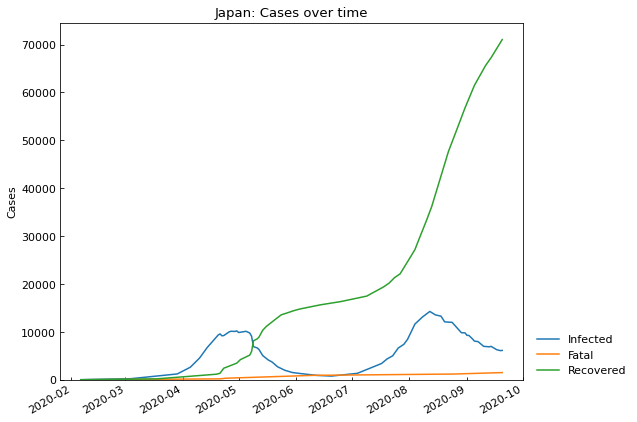

,Date,Confirmed,Infected,Fatal,Recovered
218,2020-09-16,76448,6455,1461,68532
219,2020-09-17,77009,6283,1473,69253
220,2020-09-18,77494,6113,1482,69899
221,2020-09-19,78073,6083,1495,70495
222,2020-09-20,78657,6127,1500,71030


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

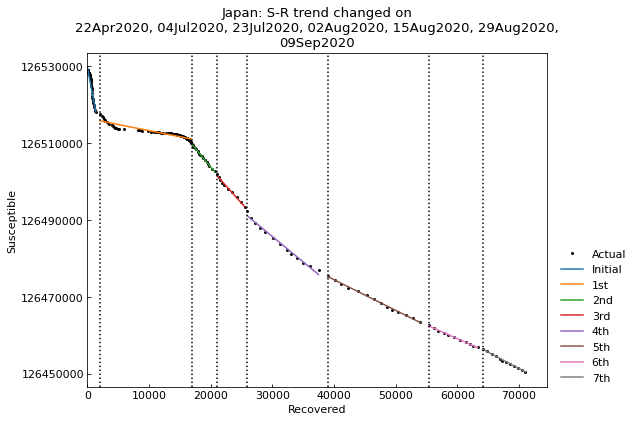

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,03Jul2020,126529100
2nd,Past,04Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,28Aug2020,126529100
6th,Past,29Aug2020,08Sep2020,126529100
7th,Past,09Sep2020,20Sep2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	7th phase (09Sep2020 - 20Sep2020): finished  524 trials in 0 min 15 sec

	1st phase (22Apr2020 - 03Jul2020): finished 1921 trials in 1 min  0 sec

	2nd phase (04Jul2020 - 22Jul2020): finished 2001 trials in 1 min  0 sec

	3rd phase (23Jul2020 - 01Aug2020): finished 2003 trials in 1 min  0 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1937 trials in 1 min  0 sec

	5th phase (15Aug2020 - 28Aug2020): finished  261 trials in 0 min  5 sec

	6th phase (29Aug2020 - 08Sep2020): finished  263 trials in 0 min  5 sec

	4th phase (02Aug2020 - 14Aug2020): finished 2168 trials in 1 min  0 sec

Completed optimization. Total: 2 min 16 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/gamma [day],1/alpha2 [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.65,0.017296,0.000069,0.025849,0.005396,360,9,46,3629,0.017,0.962479,1937,1 min 0 sec
1st,Past,22Apr2020,03Jul2020,126529100,SIR-F,0.40,0.084350,0.000186,0.007572,0.017066,360,33,14,1341,0.084,0.793123,1921,1 min 0 sec
2nd,Past,04Jul2020,22Jul2020,126529100,SIR-F,2.08,0.001088,0.000026,0.035503,0.017018,360,7,14,9563,0.001,0.039275,2001,1 min 0 sec
3rd,Past,23Jul2020,01Aug2020,126529100,SIR-F,2.06,0.000938,0.000031,0.035897,0.017340,360,6,14,7997,0.001,0.035086,2003,1 min 0 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.38,0.000492,0.000097,0.024972,0.017937,360,10,13,2575,0.000,0.084455,2168,1 min 0 sec
5th,Past,15Aug2020,28Aug2020,126529100,SIR-F,0.81,0.001486,0.000191,0.021028,0.025625,360,11,9,1308,0.001,0.023261,261,0 min 5 sec
6th,Past,29Aug2020,08Sep2020,126529100,SIR-F,0.59,0.019233,0.000059,0.016083,0.026590,360,15,9,4203,0.019,0.083471,263,0 min 5 sec
7th,Past,09Sep2020,20Sep2020,126529100,SIR-F,0.86,0.002290,0.000295,0.019730,0.022493,360,12,11,846,0.002,0.022795,524,0 min 15 sec


### Accuracy of estimation

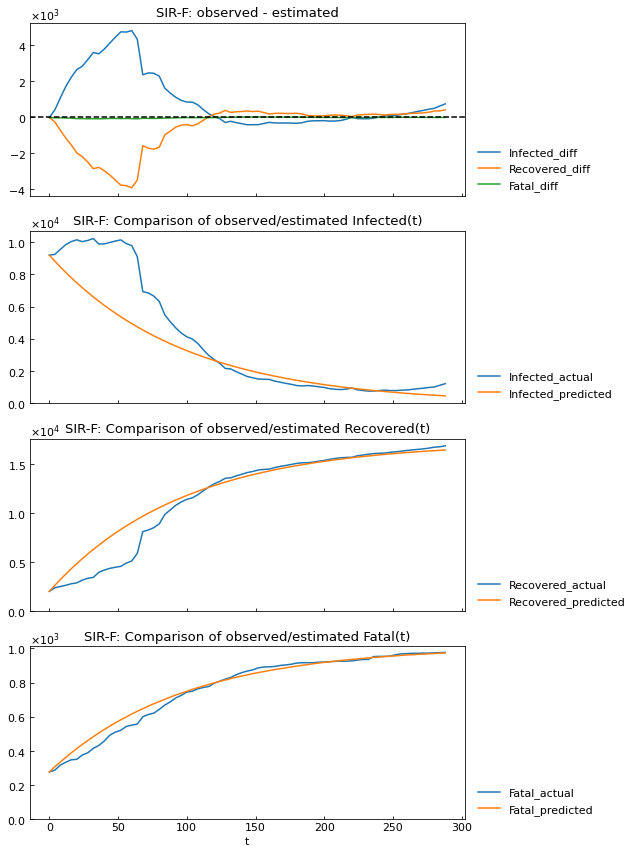

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.38

### Show parameter history

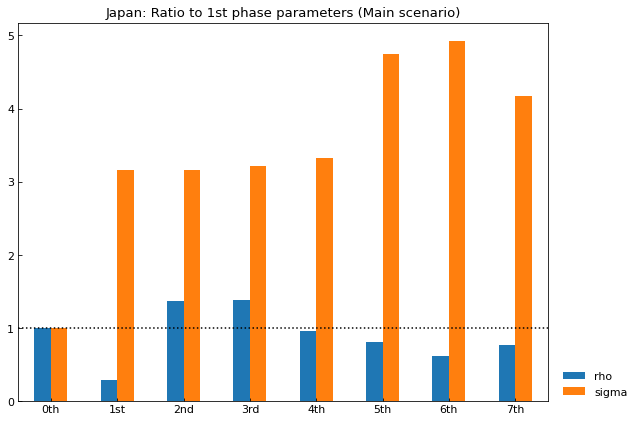

,0th,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.292941,1.373471,1.388705,0.966076,0.813499,0.622188,0.763291
sigma,1.0,3.162856,3.154008,3.213661,3.324362,4.749059,4.928068,4.168665


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

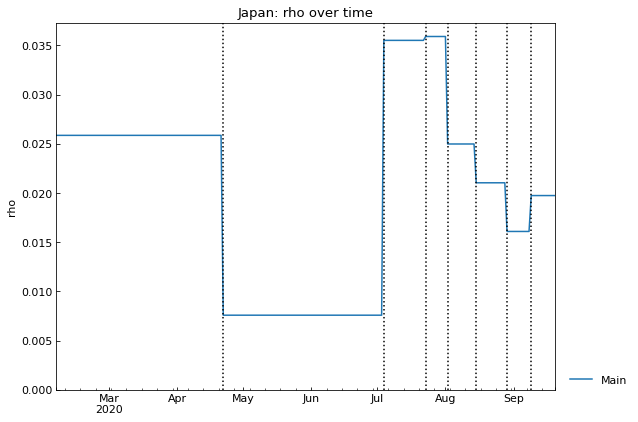

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

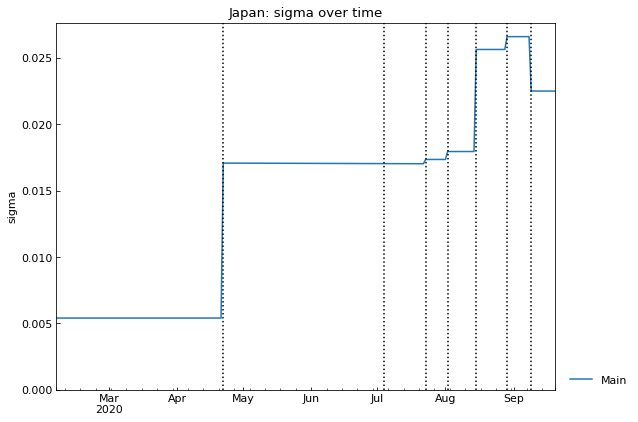

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

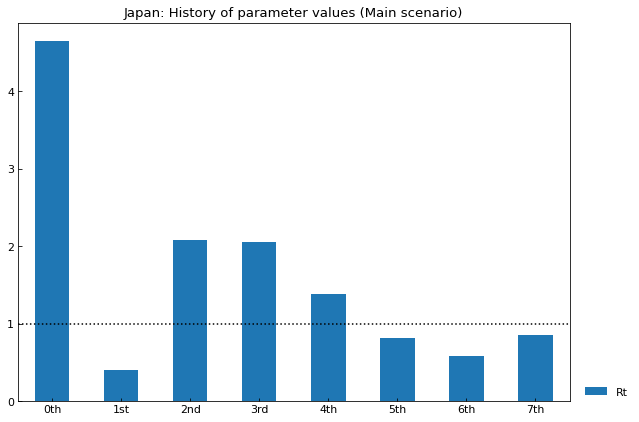

,0th,1st,2nd,3rd,4th,5th,6th,7th
Rt,4.65,0.4,2.08,2.06,1.38,0.81,0.59,0.86


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

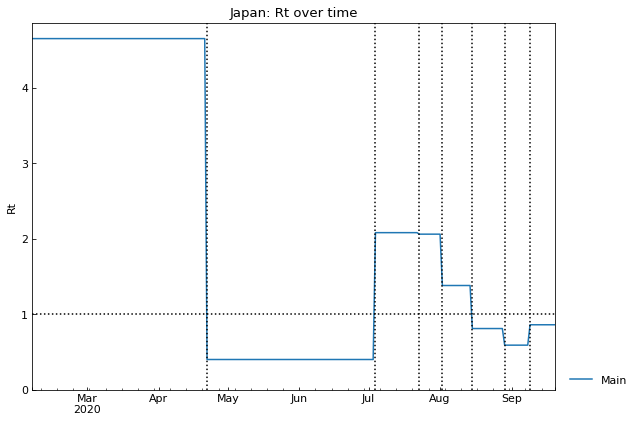

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

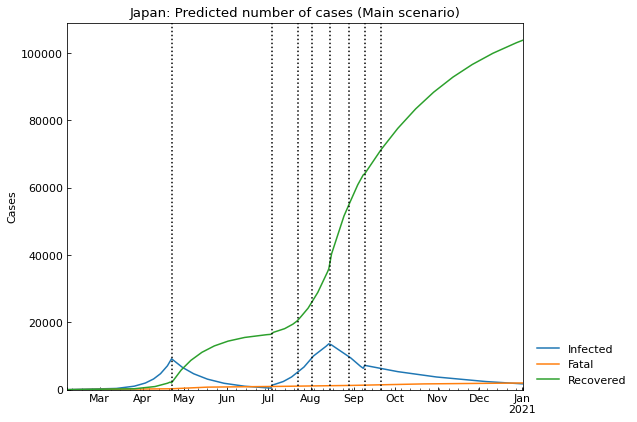

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,107001,1985,1815,103201
328,2020-12-30,107143,1988,1792,103363
329,2020-12-31,107283,1990,1770,103523
330,2021-01-01,107422,1992,1748,103682
331,2021-01-02,107559,1995,1726,103838


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.022492896548594047

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.044985793097188094

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.65   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.40   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.08   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  2.06   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.38   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.81   
         6th      Past  29Aug2020  08Sep2020   126529100  SIR-F  0.59   
         7th      Past  09Sep2020  20Sep2020   126529100  SIR-F  0.86   
         8th    Future  21Sep2020  01Jan2021   126529100  SIR-F  0.86   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.65   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.40   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.08   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  2.06   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.38   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.81   
         6th      Past  29Aug2020  08Sep2020   126529100  SIR-F  0.59   
         7th      Past  09Sep2020  20Sep2020   126529100  SIR-F  0.86   
         8th    Future  21Sep2020  20Oct2020   126529100  SIR-F  0.86   
         9th    Future  21Oct2020  01Jan2021   126529100  SIR-F  0.43   

                   theta     kappa       rho     sigma  tau  1/beta [day]  \
Scenario Phase                                                              
Main     0th    0.017296  0.000069  0.025849  0.005396  360             9   
         1st    0.084350  0.000186  0.007572  0.017066  360            33   
         2nd    0.001088  0.000026  0.035503  0.017018  360             7   
         3rd    0.000938  0.000031  0.035897  0.017340  360             6   
         4th    0.000492  0.000097  0.024972  0.017937  360            10   
         5th    0.001486  0.000191  0.021028  0.025625  360            11   
         6th    0.019233  0.000059  0.016083  0.026590  360            15   
         7th    0.002290  0.000295  0.019730  0.022493  360            12   
         8th    0.002290  0.000295  0.019730  0.022493  360            12   
Medicine 0th    0.017296  0.000069  0.025849  0.005396  360             9   
         1st    0.084350  0.000186  0.007572  0.017066  360            33   
         2nd    0.001088  0.000026  0.035503  0.017018  360             7   
         3rd    0.000938  0.000031  0.035897  0.017340  360             6   
         4th    0.000492  0.000097  0.024972  0.017937  360            10   
         5th    0.001486  0.000191  0.021028  0.025625  360            11   
         6th    0.019233  0.000059  0.016083  0.026590  360            15   
         7th    0.002290  0.000295  0.019730  0.022493  360            12   
         8th    0.002290  0.000295  0.019730  0.022493  360            12   
         9th    0.002290  0.000295  0.019730  0.044986  360            12   

                1/gamma [day]  1/alpha2 [day]  alpha1 [-]      RMSLE Trials  \
Scenario Phase                                                                
Main     0th               46            3629       0.017   0.962479   1937   
         1st               14            1341       0.084   0.793123   1921   
         2nd               14            9563       0.001  0.0392746   2001   
         3rd               14            7997       0.001  0.0350864   2003   
         4th               13            2575       0.000  0.0844546   2168   
         5th                9            1308       0.001  0.0232612    261   
         6th                9            4203       0.019  0.0834713    263   
         7th               11             846       0.002  0.0227949    524   
         8th               11             846       0.002          -      - 

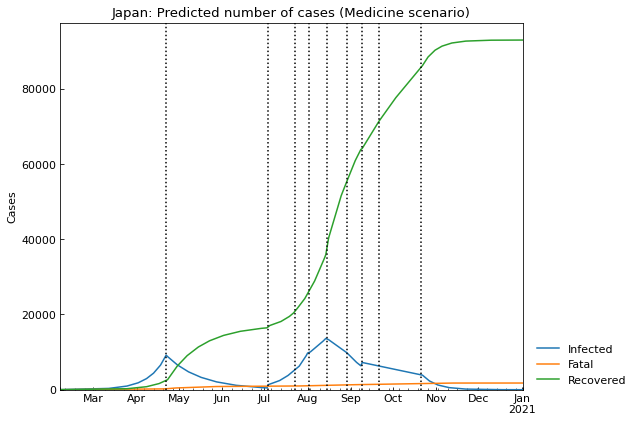

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,94678,1772,4,92902
328,2020-12-30,94678,1772,3,92903
329,2020-12-31,94678,1772,3,92903
330,2021-01-01,94679,1772,3,92904
331,2021-01-02,94678,1772,2,92904


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,9th_Rt
Main,13620,14Aug2020,1726,1995,-
Medicine,13620,14Aug2020,2,1772,0.43


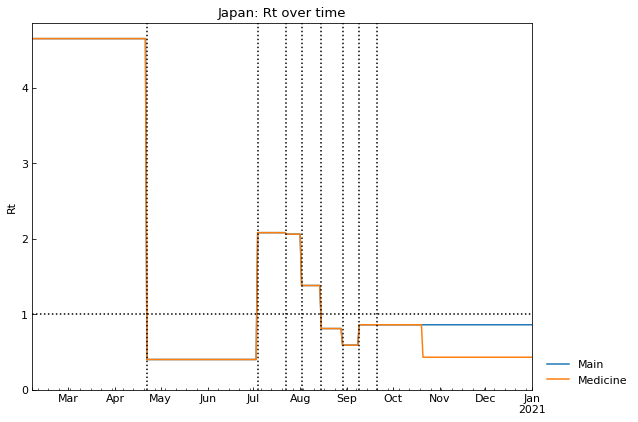

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

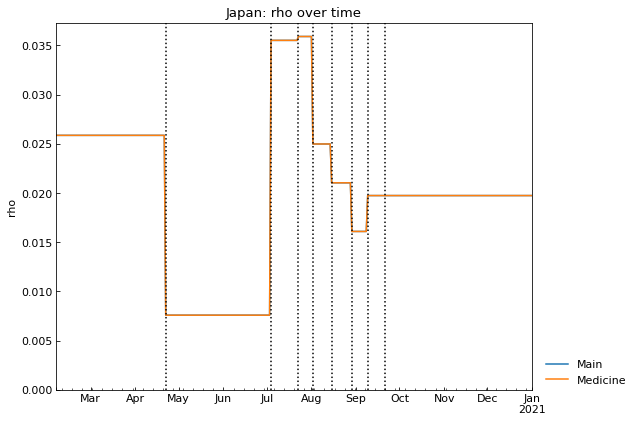

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

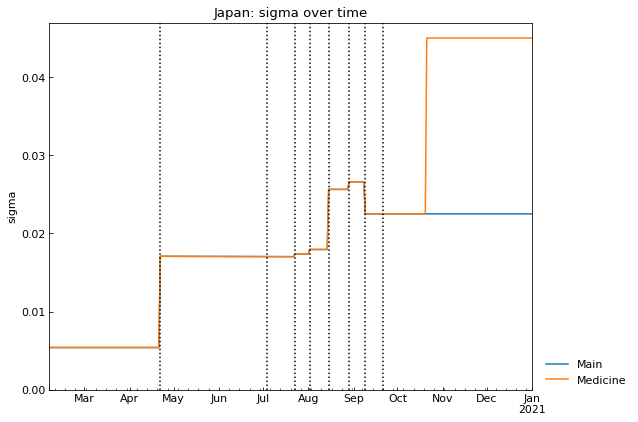

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

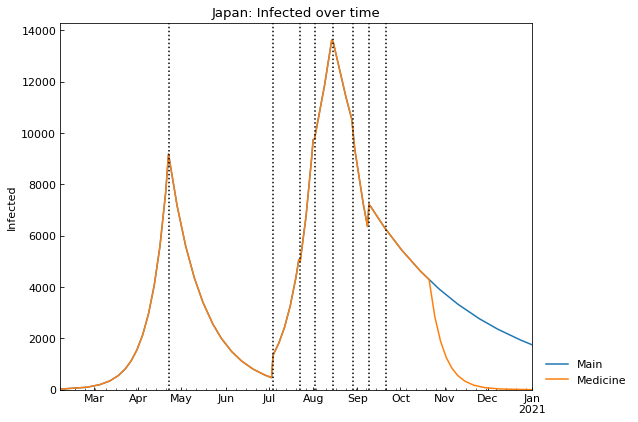

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")